In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 

In [2]:
lanl_log = '../pretrained/rw_sampling/lanl14argus/rw_bert_lanl14argus_log_tiny.txt'
lanl_df = pd.read_csv(lanl_log, names=['loss', 'updates', 'tokens', 'time'])

unsw_log = '../pretrained/rw_sampling/unsw/rw_bert_unsw_log_tiny.txt'
unsw_df = pd.read_csv(unsw_log, names=['loss', 'updates', 'tokens', 'time'])

optc_log = '../pretrained/rw_sampling/optc/rw_bert_optc_log_tiny.txt'
optc_df = pd.read_csv(optc_log, names=['loss', 'updates', 'tokens', 'time'])

In [3]:
lanl_df['time'].sum()

1614.5975489616394

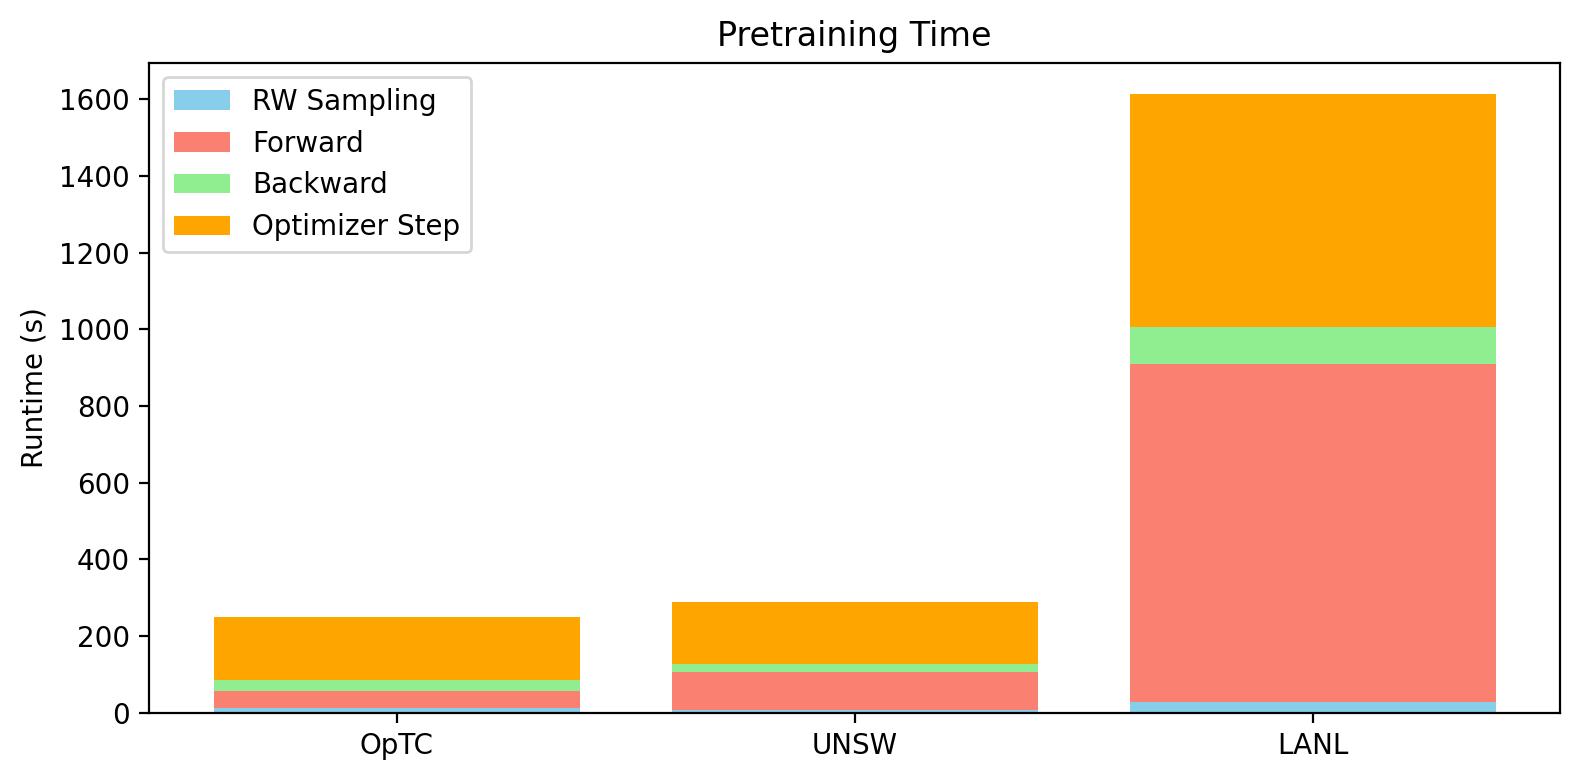

In [4]:
import numpy as np 
df_map = {'optc': optc_df, 'unsw': unsw_df, 'lanl': lanl_df}

print()

rows = []
for ds in ['optc', 'unsw', 'lanl']:
    latency_df = pd.read_csv(f'../latency/latency_{ds}.csv')
    l = latency_df.sum().to_dict()
    
    # Normalize
    tot = sum(l.values())
    for k in l: 
        l[k] /= tot 

    l['dataset'] = ds 
    l['total'] = df_map[ds]['time'].sum()

    rows.append(l)

# Extract data
datasets = ['OpTC', 'UNSW', 'LANL']
totals = [r['total'] for r in rows]

# The categories for stacking
parts = ['samp', 'fwd', 'bwd', 'step']
labels = ['RW Sampling', 'Forward', 'Backward', 'Optimizer Step']
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']

# Build stacked values (proportion * total)
stacked_values = {part: [r[part] * r['total'] for r in rows] for part in parts}

# Plot
x = np.arange(len(rows))
plt.figure(figsize=(8, 4), dpi=200)

bottom = np.zeros(len(rows))
for i,part in enumerate(parts):
    plt.bar(x, stacked_values[part], bottom=bottom, label=labels[i], color=colors[i])
    bottom += stacked_values[part]

plt.xticks(x, datasets)
plt.ylabel("Runtime (s)")
plt.title("Pretraining Time")
plt.legend()

plt.tight_layout()
plt.show()

[{'samp': 0.4442744255065918, 'fwd': 2.020228862762451, 'bwd': 2.3324759006500244, 'step': 0.6156094074249268, 'dataset': 'optc'}, {'samp': 1.0081689357757568, 'fwd': 9.253035545349121, 'bwd': 5.687947750091553, 'step': 1.2389419078826904, 'dataset': 'unsw'}, {'samp': 1.2463243007659912, 'fwd': 61.282833099365234, 'bwd': 6.08300256729126, 'step': 1.4582335948944092, 'dataset': 'lanl'}]


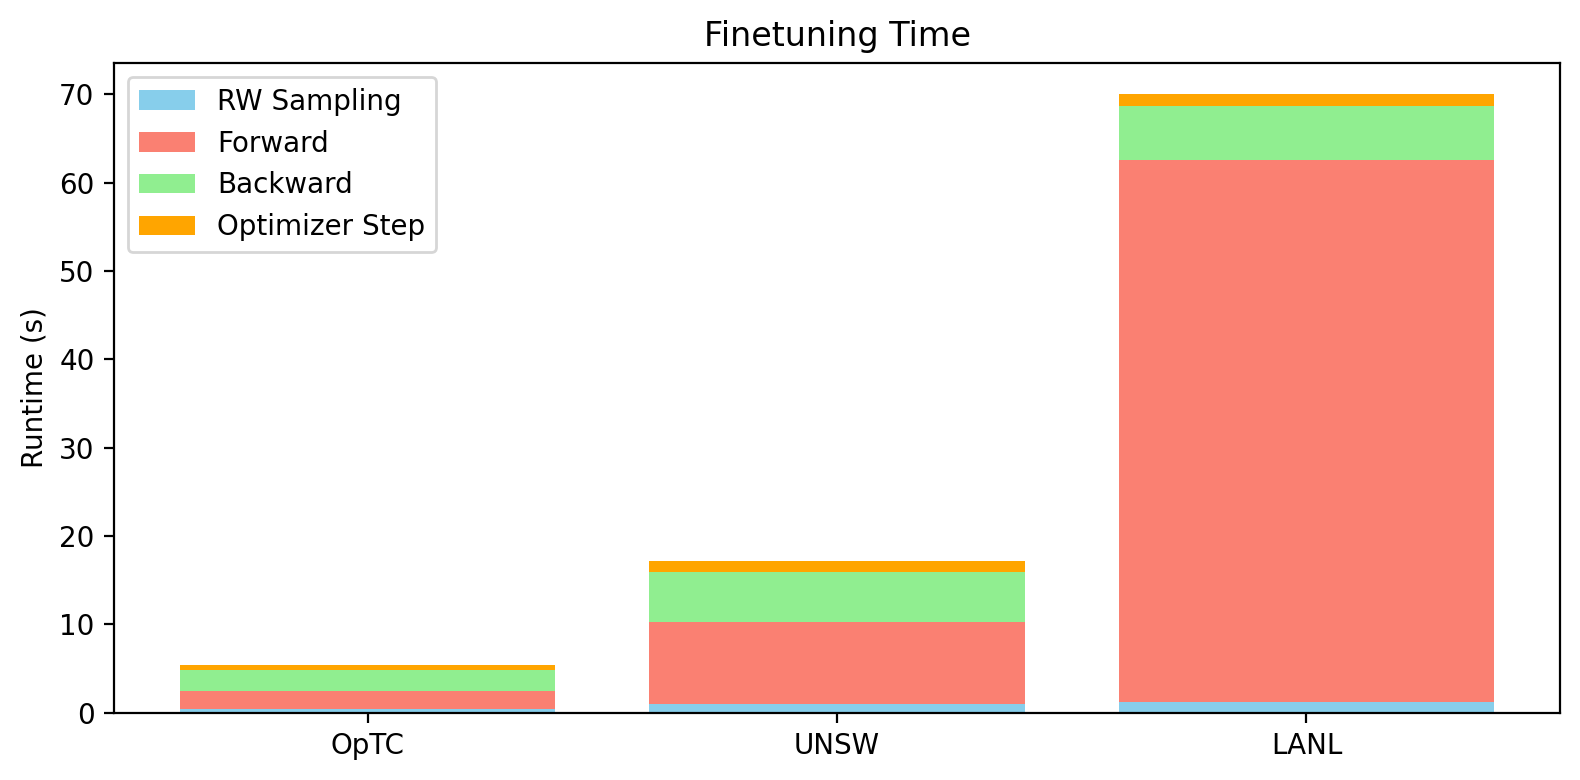

In [5]:
import json 
rows = []
for ds in ['optc', 'unsw', 'lanl']:
    with open(f'../latency/latency_{ds}_ft.json', 'r') as f:
        latency = json.load(f)

    for k in latency: 
        latency[k] = sum(latency[k])
    
    latency['dataset'] = ds 
    rows.append(latency)

print(rows)

# Extract data
datasets = ['OpTC', 'UNSW', 'LANL']

# The categories for stacking
parts = ['samp', 'fwd', 'bwd', 'step']
labels = ['RW Sampling', 'Forward', 'Backward', 'Optimizer Step']
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']

# Build stacked values (proportion * total)
stacked_values = {part: [r[part] for r in rows] for part in parts}

# Plot
x = np.arange(len(rows))
plt.figure(figsize=(8, 4), dpi=200)

bottom = np.zeros(len(rows))
for i,part in enumerate(parts):
    plt.bar(x, stacked_values[part], bottom=bottom, label=labels[i], color=colors[i])
    bottom += stacked_values[part]

plt.xticks(x, datasets)
plt.ylabel("Runtime (s)")
plt.title("Finetuning Time")
plt.legend()

plt.tight_layout()
plt.show()

{'RW Sampling': [0.0, 0.0, 2.0591366291046143], 'Forward': [9.558577537536621, 134.87125873565674, 34.068357944488525], 'Backward': [4.975336790084839, 137.5553274154663, 12.364436388015747], 'Optimizer Step': [0.5640184879302979, 0.34156322479248047, 3.015933036804199], 'Pretraining': [0.0, 0.0, 248.2241]}


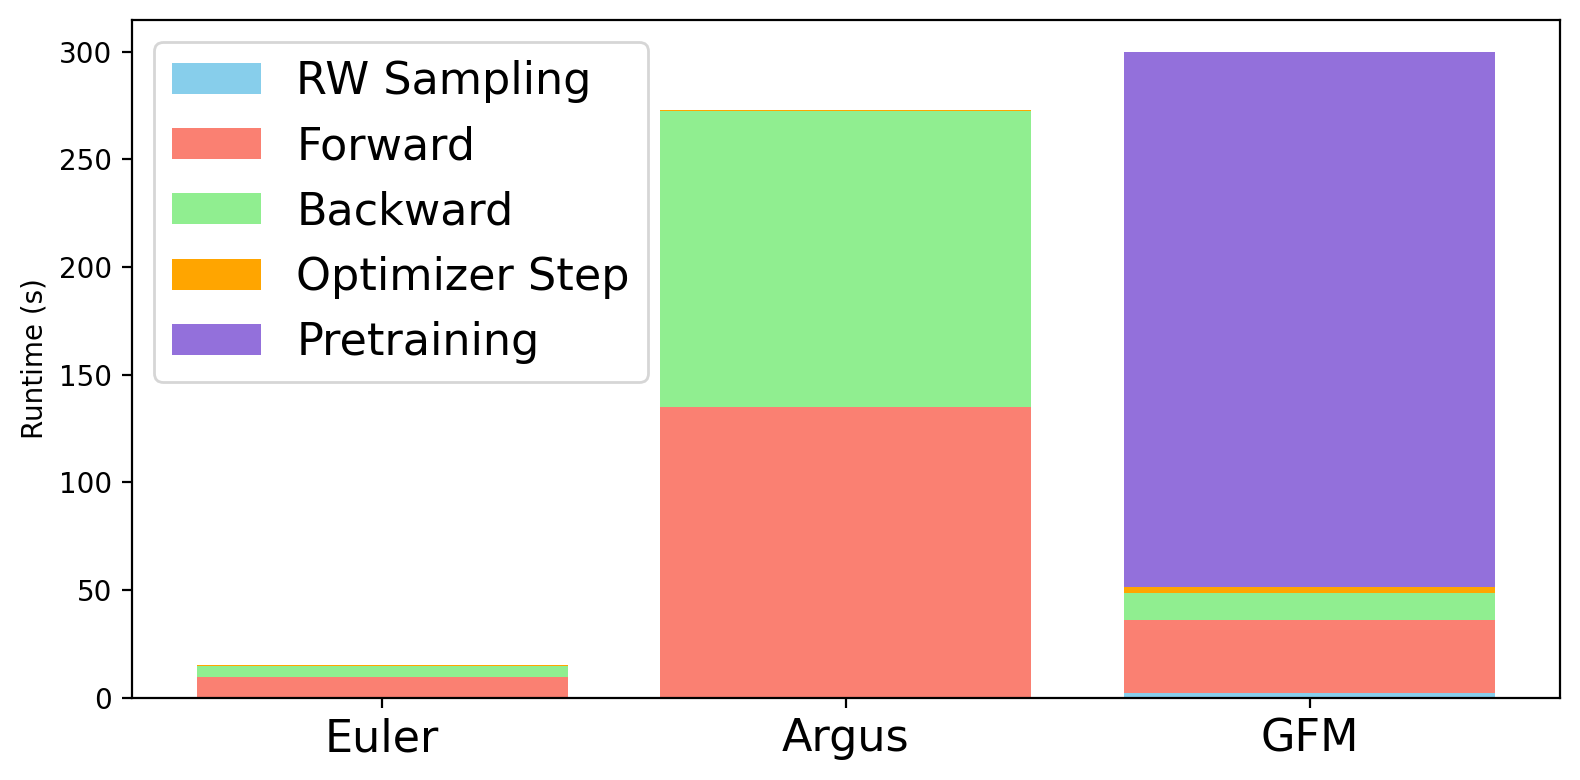

{'RW Sampling': [0.0, 0.0, 5.040844678878784], 'Forward': [23.49400520324707, 55.91660022735596, 46.265177726745605], 'Backward': [12.747513055801392, 49.06424522399902, 28.439738750457764], 'Optimizer Step': [0.5745184421539307, 0.377655029296875, 6.194709539413452], 'Pretraining': [0.0, 0.0, 288.9138]}


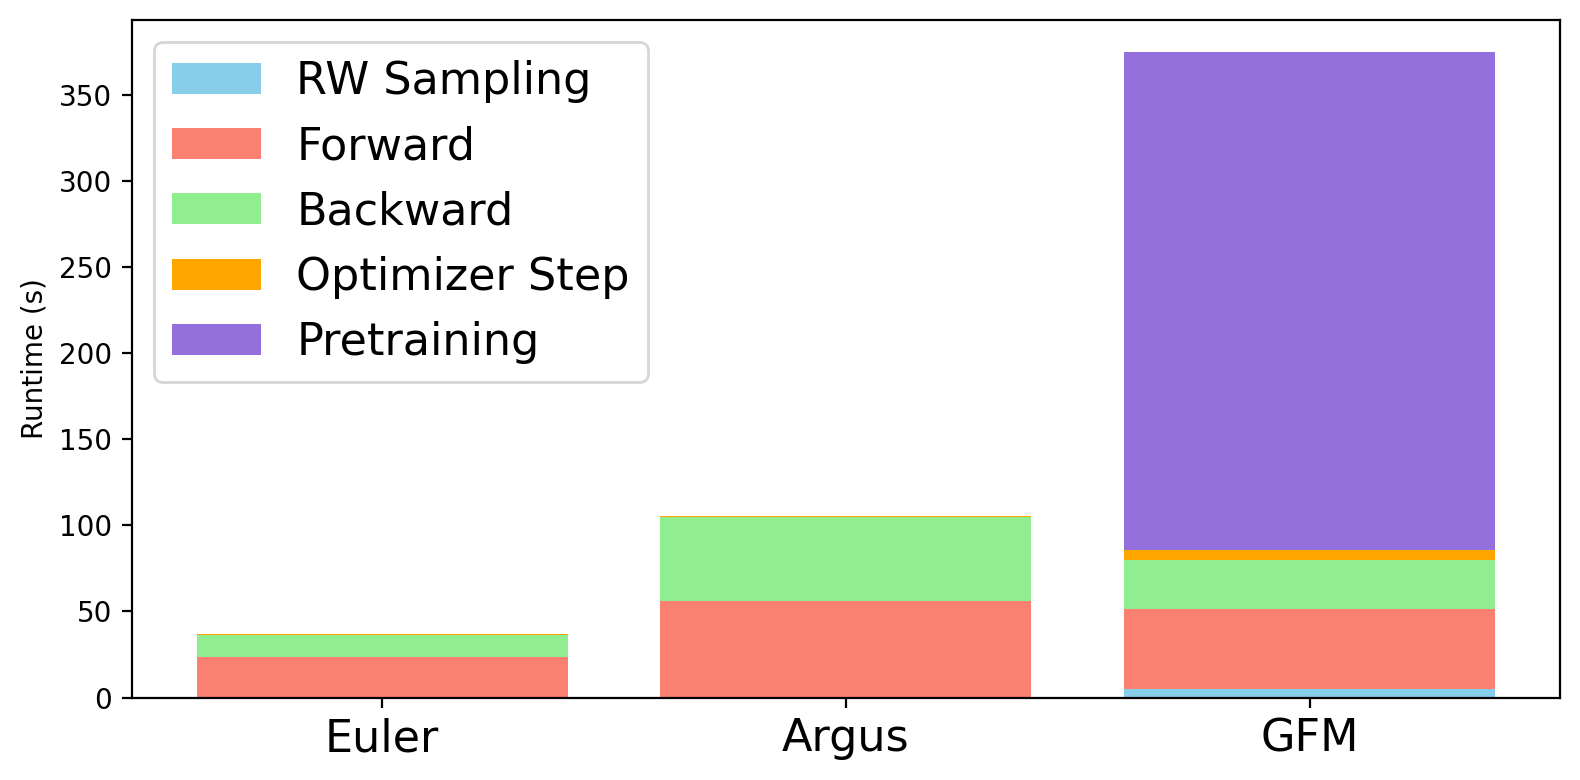

{'RW Sampling': [0.0, 0.0, 6.231621503829956], 'Forward': [77.82160878181458, 2700.575280189514, 306.4141654968262], 'Backward': [14.30686354637146, 5710.504801273346, 30.4150128364563], 'Optimizer Step': [2.7970147132873535, 4.51601505279541, 7.291167974472046], 'Pretraining': [0.0, 0.0, 1614.598]}


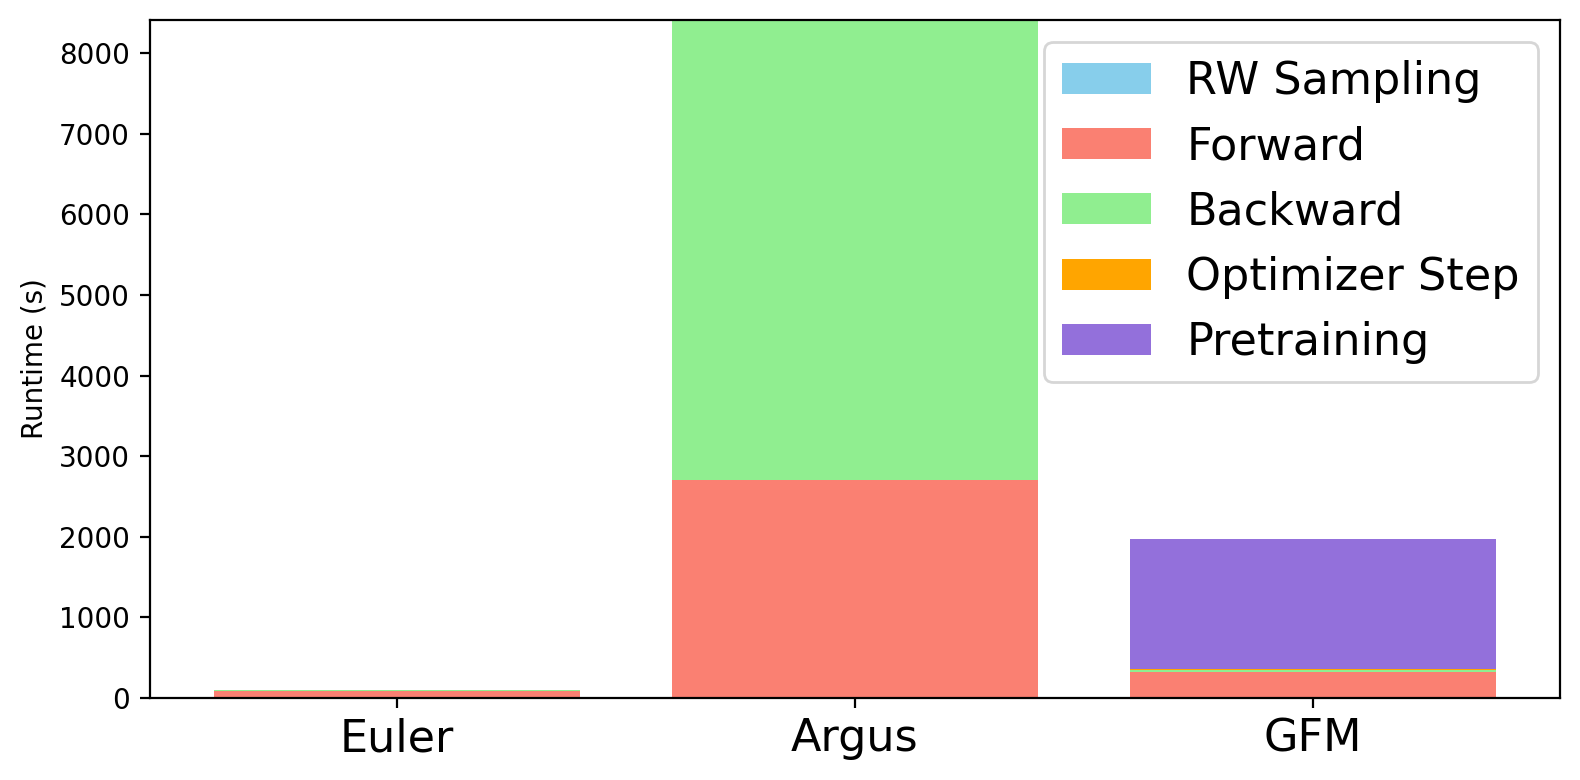

In [6]:
finetune_epochs = {'Euler': 15, 'Argus': 10, 'GFM': 5}
num_nodes = {'optc': 1000, 'unsw': 50, 'lanl': 14000}

for ds in ['optc', 'unsw', 'lanl']:
    models = []
    times = []
    with open(f'../latency/comparison/{ds}_latencies.csv', 'r') as f: 
        line = f.readline() 
        while line: 
            tokens = line.split(',')
            model = tokens[0]
            models.append(model)

            ts =  [float(t) for t in tokens[1:]]
            ts[1] += ts[2]
            ts = ts[:2] + ts[3:]
            for i in range(len(ts)-1): 
                ts[i] *= finetune_epochs[model]

            times.append(ts)
            line = f.readline()

    labels = ['RW Sampling', 'Forward', 'Backward', 'Optimizer Step', 'Pretraining']
    colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'mediumpurple']

    # Build stacked values (proportion * total)
    stacked_values = {part: [r[i] for r in times] for i,part in enumerate(labels)}
    print(stacked_values)

    # Plot
    x = np.arange(len(models))
    plt.figure(figsize=(8, 4), dpi=200)

    bottom = np.zeros(len(models))
    for i,part in enumerate(labels):
        plt.bar(x, stacked_values[part], bottom=bottom, label=labels[i], color=colors[i])
        bottom += stacked_values[part]

    plt.xticks(x, models, size=16)
    plt.ylabel("Runtime (s)")
    #plt.title(f"Training Time per Epoch ({ds.upper().replace('P', 'p')})")
    plt.legend(fontsize=16)

    plt.tight_layout()
    plt.show()